# Individual subject averages



In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from glob import glob
from pathlib import Path
import yaml
from yaml import CLoader as Loader
import os.path as op
import pyarrow.feather as feather

import mne
import mne.stats
from mne.stats import linear_regression, fdr_correction
from mne.viz import plot_compare_evokeds
from mne.channels import find_ch_adjacency, make_1020_channel_selections

from mne.stats import spatio_temporal_cluster_test
from scipy.stats import ttest_ind, zscore
from statsmodels.stats.multitest import multipletests

mne.set_log_level(verbose='error')

pd.set_option('display.max_rows', None)

## Read config file

In [16]:
bids_root = '../..'

cfg_file = op.join(bids_root, 'config.yml')
with open(cfg_file, 'r') as f:
    config = yaml.load(f, Loader=Loader)

study_name = config['study_name']
task = config['task']
data_type = config['data_type']
eog = config['eog']
montage_fname = config['montage_fname']

epoch_p =  {k: v for d in config['analysis_settings'] for k, v in d.items()}
outlier_thresh = epoch_p['outlier_thresh']

baseline = eval(epoch_p['baseline'])

# comp =  {k: v for d in config['components'] for k, v in d.items()}
components = config['components']


## Paths

In [8]:
source_path = op.join(bids_root, 'derivatives', 'erp_preprocessing')

derivatives_path = op.join(bids_root, 'derivatives', 'erp_indiv_subject_analysis')
if Path(derivatives_path).exists() == False:
    Path(derivatives_path).mkdir(parents=True)
    
out_path = op.join(derivatives_path, 'data')
if Path(out_path).exists() == False:
    Path(out_path).mkdir(parents=True)

report_path = op.join(derivatives_path, 'reports')
if Path(report_path).exists() == False:
    Path(report_path).mkdir(parents=True)

fig_path = op.join(derivatives_path, 'figures')
if Path(fig_path).exists() == False:
    Path(fig_path).mkdir(parents=True) 
   
waveplot_figsize = (18, 6)
fig_format = 'pdf'
waveplot_stem = fig_path + '/waveforms_'
   
    
epochs_suffix = '-epo.fif'

## List of subjects

In [9]:
prefix = 'sub-'
subjects = sorted([s[-7:] for s in glob(source_path + '/' + prefix + '*')])
print("n subjects = ", len(subjects))
print(subjects)

n subjects =  5
['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005']


## Define conditions and labels

In [10]:
conditions = ['Angry/Grey/target', 'Angry/Grey/nontarget',
              'Angry/Red/target', 'Angry/Red/nontarget',
              'Neutral/Grey/target', 'Neutral/Grey/nontarget',
              'Neutral/Red/target', 'Neutral/Red/nontarget',
              'target', 'nontarget'
             ]

coi = ['target', 'nontarget']

contrasts = {'Angry/Grey':['Angry/Grey/target', 'Angry/Grey/nontarget'],
             'Angry/Red':['Angry/Red/target', 'Angry/Red/nontarget'],
             'Neutral/Grey':['Neutral/Grey/target', 'Neutral/Grey/nontarget'],
             'Neutral/Red':['Neutral/Red/target', 'Neutral/Red/nontarget'],
             'Target-Nontarget':['target', 'nontarget']
            }

## Load in data

In [11]:
epochs = {}
for subject in subjects:
    subj_path = op.join(source_path, subject, 'eeg')
    epochs[subject] = mne.read_epochs(str(subj_path + '/' + subject + '_task-' + task + '-epo.fif'),
                                         verbose=None, 
                                         preload=True)


## Create evokeds
Averages over trials for each subject

In [12]:
evoked = {}
for subject in subjects:
    evoked[subject] = {cond:epochs[subject][cond].average().apply_baseline(baseline)
                       for cond in conditions
                      }

## Create Difference waves


In [13]:
diff = {}
for subject in subjects:
    diff[subject] = {contr:mne.combine_evoked([evoked[subject][contrasts[contr][0]], 
                                               -evoked[subject][contrasts[contr][1]]],
                                              weights='equal')
                     for contr in contrasts}

## Grand Averages

In [14]:
gavg = {}
for cond in conditions:
    gavg[cond] = mne.grand_average([epochs[subject][cond].average() for subject in subjects])

## Plot montage


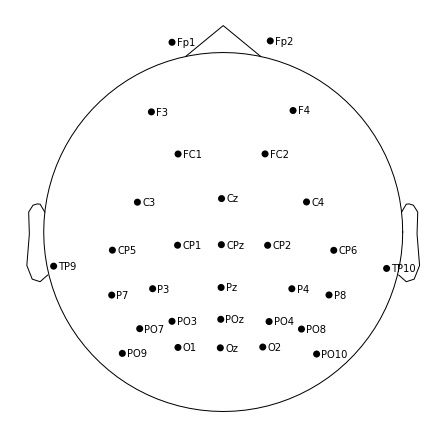

In [15]:
gavg[conditions[0]].plot_sensors(show_names=True) #.savefig(fig_path + '/montage.' + fig_format)
plt.show()

## Define region of interest (ROI)

Cluster of electrodes around the vertex, where we expect N400 to be largest

In [19]:
# convoluted unpacking from yaml
rois = {k: v for d in config['rois'] for k, v in d.items()}
for roi, chs in rois.items():
    rois[roi]= [c.split(', ') for c in chs][0]

#### Create mask identifying ROI electrodes

In [20]:
chs = pd.Series(gavg[conditions[0]].ch_names)

roi_elec = [i for c in rois.values() for i in c ]
mask = chs.isin(roi_elec).to_numpy()
num_tp = gavg[conditions[0]].data.shape[1]
mask = np.repeat(mask[:, np.newaxis], num_tp, axis=1)

---
## Visualization

## Joint plot of grand averages

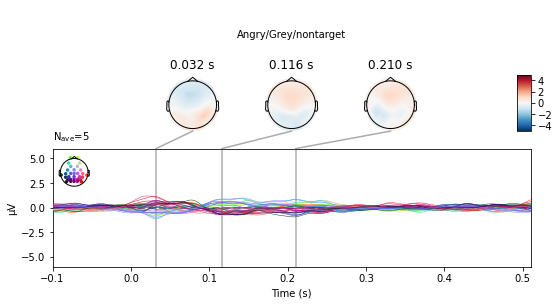

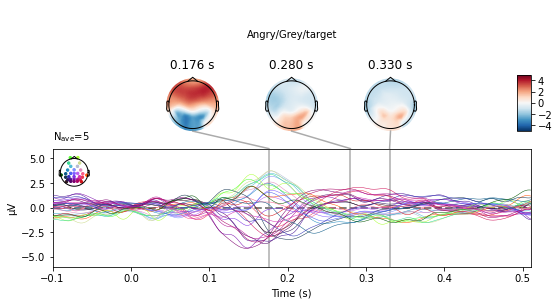

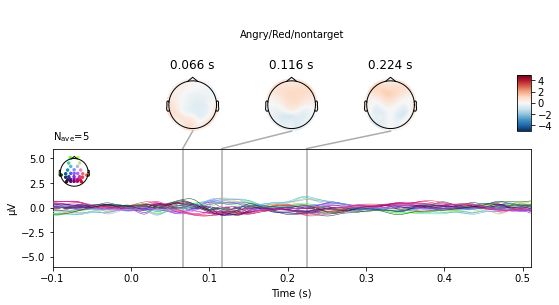

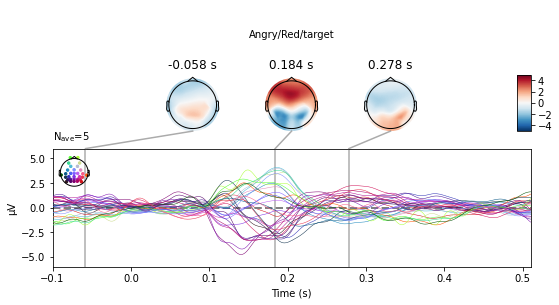

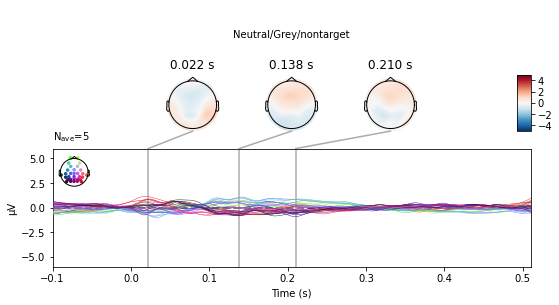

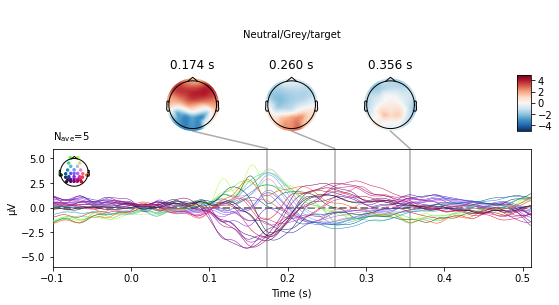

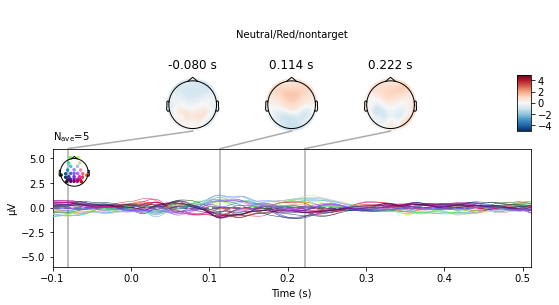

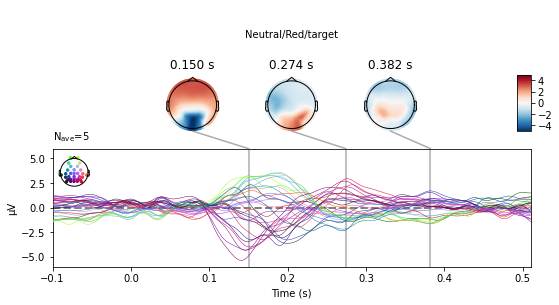

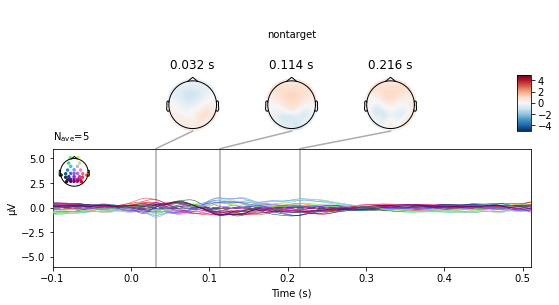

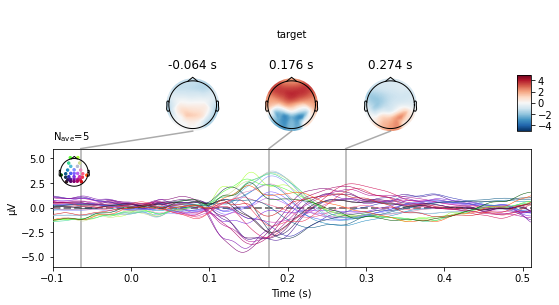

In [13]:
uv_range = 5
ylim = 6

for cond in sorted(conditions):
    gavg[cond].plot_joint(title=(cond), 
                             ts_args={'hline':[0], 
                                      'ylim':{'eeg':[-ylim, ylim]}
                                      },
                             topomap_args={'sensors':False, 'contours':False, 
                                           'vmin':-uv_range, 'vmax':uv_range}
                            ) #.savefig(jointplot_stem + cond + '.' + fig_format)     

## Plot grand averaged waveforms
Across all participants

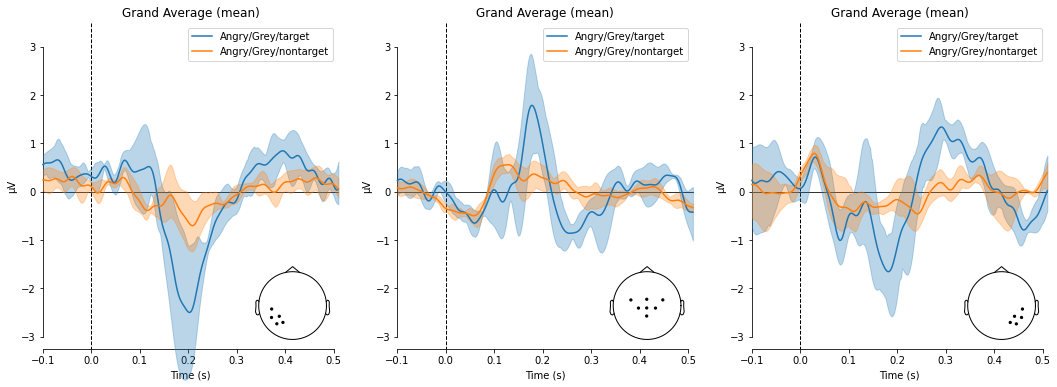

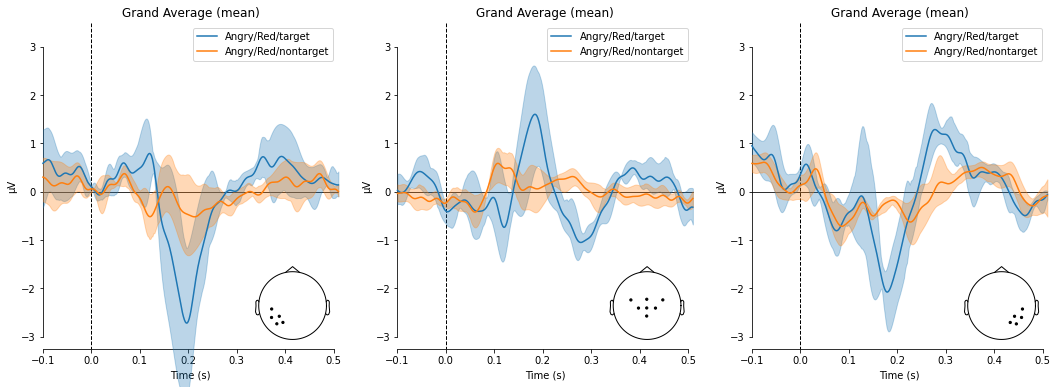

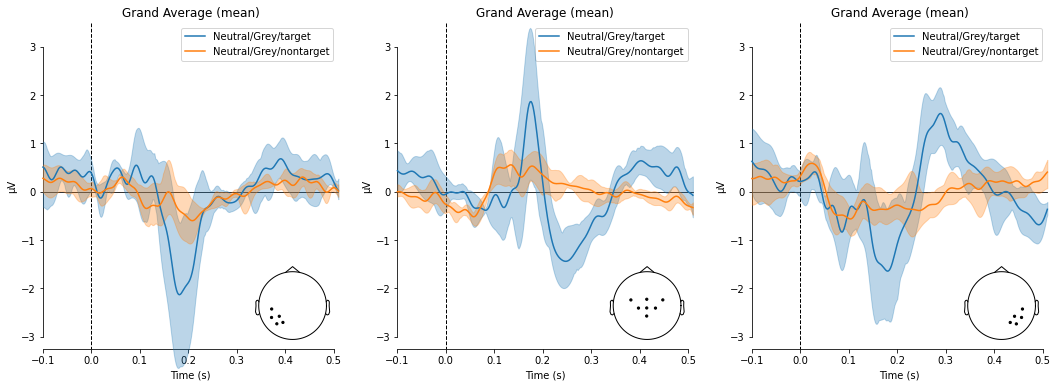

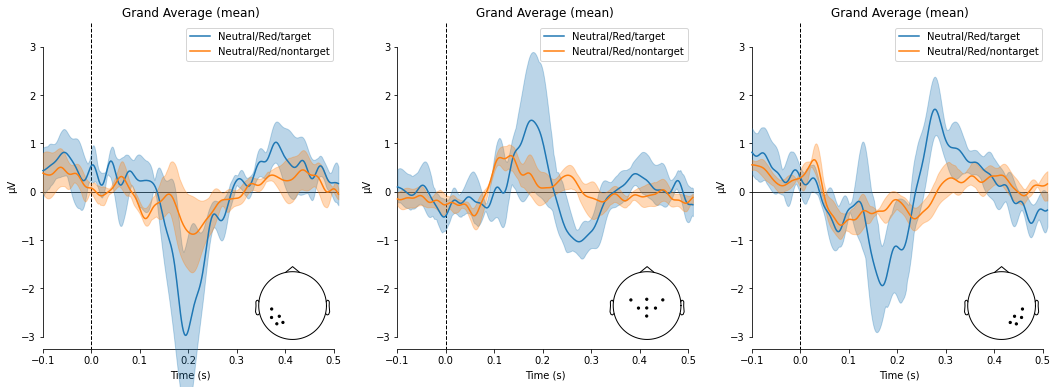

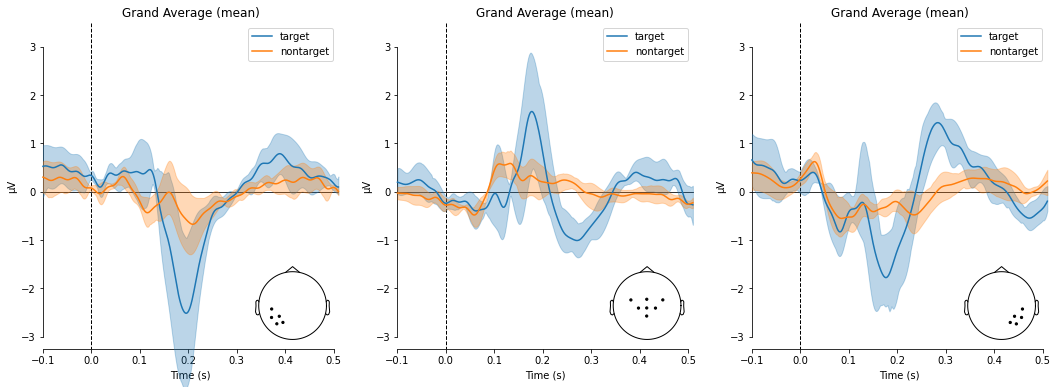

In [14]:
evk = {}
for cond in conditions:
    evk[cond] = [epochs[subject][cond].average() for subject in subjects]
    
ylim = {'eeg':[-3.25, 3.5]}
panels = 3 

for contr, conds in contrasts.items():
    fig, axs = plt.subplots(1, panels, figsize=waveplot_figsize)    
    ax = 0
    if ax < panels - 1:
        show=False
    else:
        show=True
    for roi, chans in rois.items():
        mne.viz.plot_compare_evokeds({c:evk[c] for c in conds},
                                    picks=chans,
                                    combine='mean',
                                    title='Grand Average',
                                    ylim=ylim,
                                    legend='upper right',
                                    show_sensors='lower right',
                                    axes=axs[ax], show=show
                                );     
        ax += 1
    fig.savefig(waveplot_stem + 'grandavg_' + '_'.join(contr.split('/')) + '.' + fig_format)

## Difference waves

In [51]:
evoked_diff = {}

for contr, conds in contrasts.items():
    evoked_diff[contr] = [mne.combine_evoked([ c1, c2],
                                             weights=[1, -1])
                          for (c1, c2) in zip(evk[conds[0]], evk[conds[1]])
                         ]
    

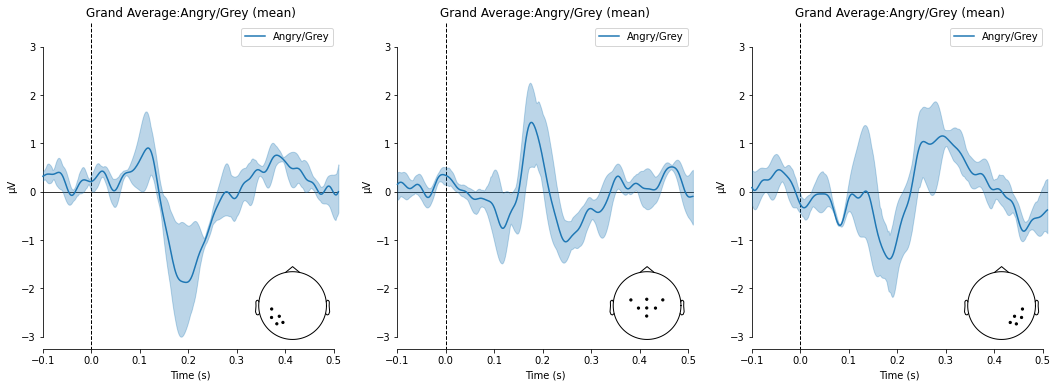

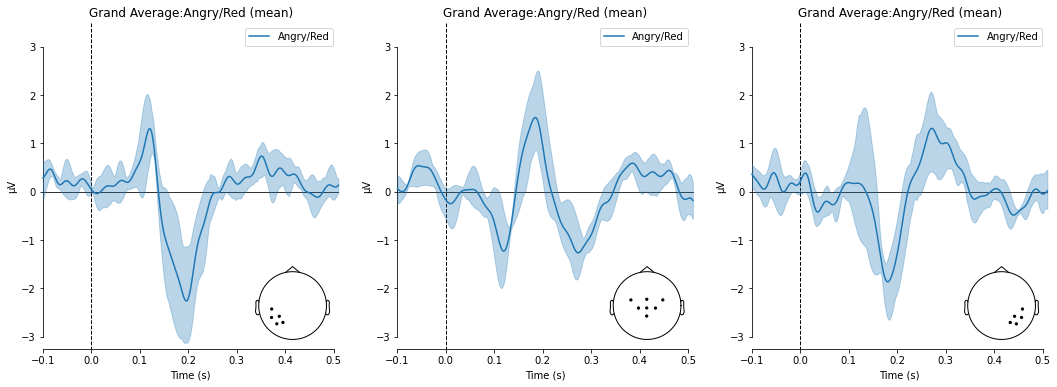

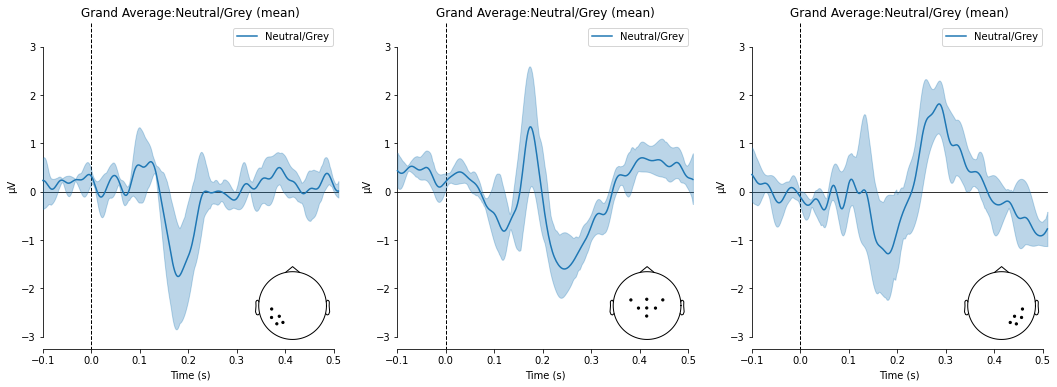

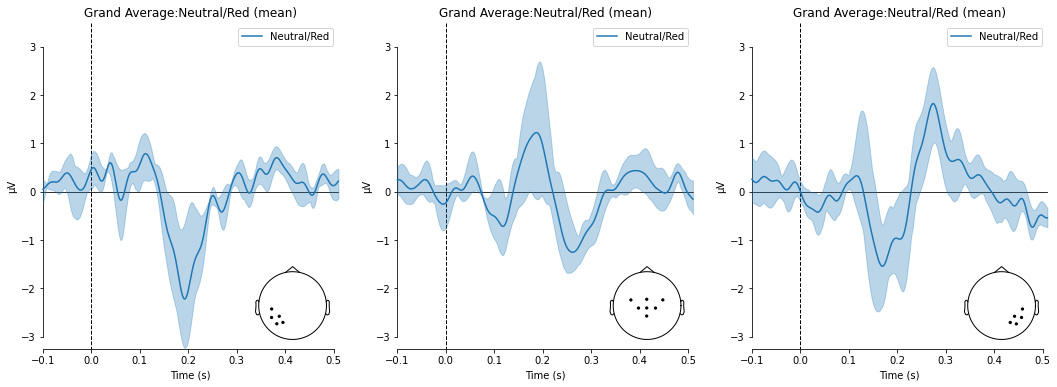

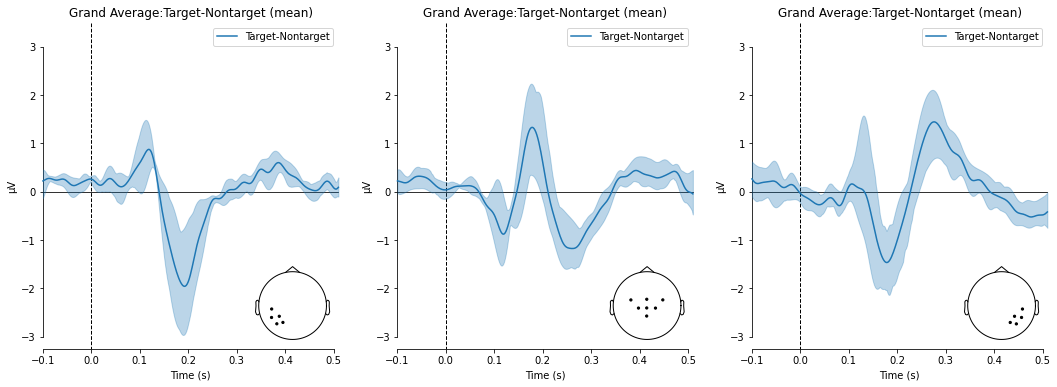

In [44]:
ylim = {'eeg':[-3.25, 3.5]}
panels = 3 

for contr in contrasts:
    fig, axs = plt.subplots(1, panels, figsize=waveplot_figsize)    
    ax = 0
    if ax < panels - 1:
        show=False
    else:
        show=True
    for roi, chans in rois.items():
        mne.viz.plot_compare_evokeds({contr:evoked_diff[contr]},
                                    picks=chans,
                                    combine='mean',
                                    title='Grand Average:' + contr,
                                    ylim=ylim,
                                    legend='upper right',
                                    show_sensors='lower right',
                                    axes=axs[ax], show=show
                                );     
        ax += 1
    fig.savefig(waveplot_stem + 'grandavg_diff_' + '_'.join(contr.split('/')) + '.' + fig_format)

## Show all difference waveforms overlaid

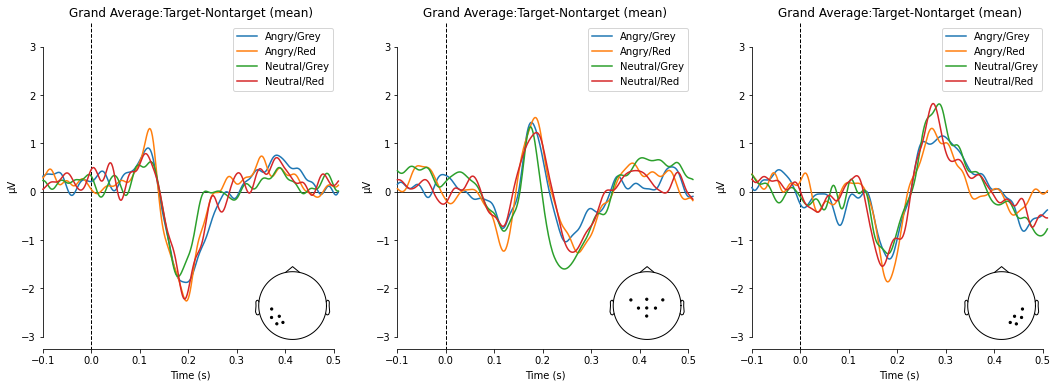

In [49]:
cond_contr = ['Angry/Grey', 'Angry/Red', 'Neutral/Grey', 'Neutral/Red']
   
ylim = {'eeg':[-3.25, 3.5]}
panels = 3 


fig, axs = plt.subplots(1, panels, figsize=waveplot_figsize)    
ax = 0
if ax < panels - 1:
    show=False
else:
    show=True
for roi, chans in rois.items():
    mne.viz.plot_compare_evokeds({contr:evoked_diff[contr] for contr in cond_contr},
                                 picks=chans,
                                 combine='mean',
                                 title='Grand Average:' + contr,
                                 ylim=ylim,
                                 legend='upper right',
                                 show_sensors='lower right',
                                 ci=False, 
                                 axes=axs[ax], show=show
                            );     
    ax += 1
fig.savefig(waveplot_stem + 'grandavg_diff_' + '_all.' + fig_format)

## Topo maps

In [55]:
mne.grand_average(evoked_diff[contr])

<Evoked | 'Grand average (n = 5)' (average, N=5), -0.1 – 0.51 sec, baseline off, 31 ch, ~124 kB>

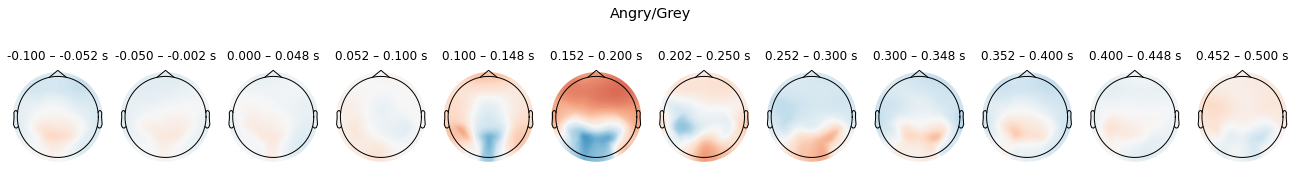

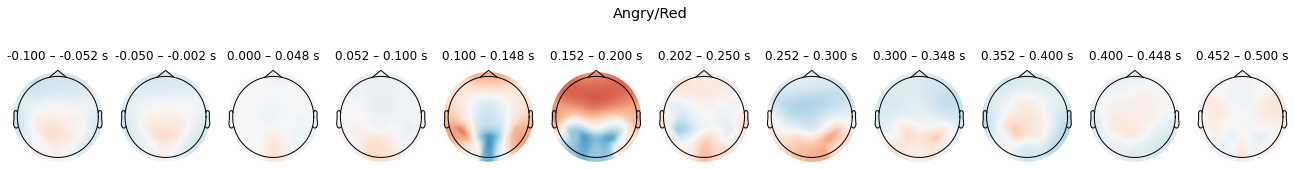

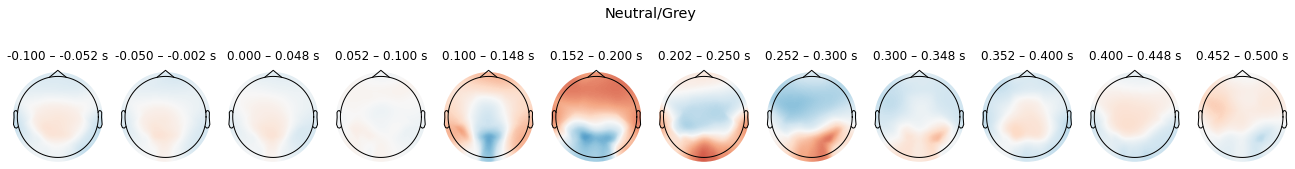

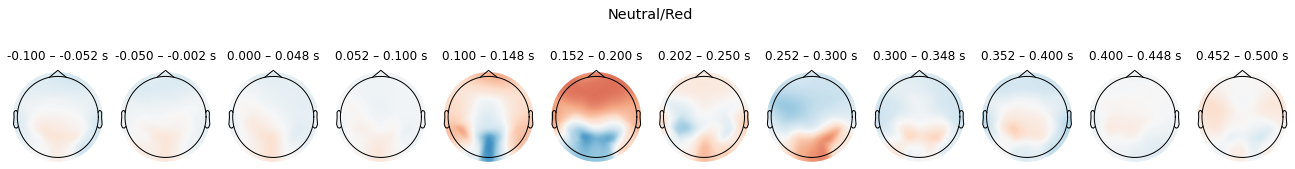

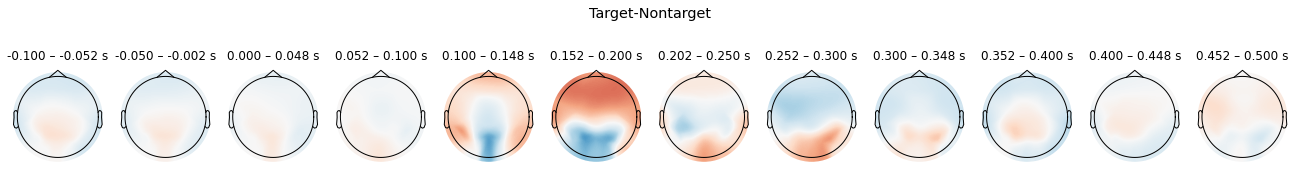

In [59]:
vlim = [-5, 5]
  

for contr in contrasts:
    fig = mne.grand_average(evoked_diff[contr]).plot_topomap(np.arange(diff[subject][contr].tmin + .025, diff[subject][contr].tmax , .050), average=0.050,
                                          show_names=False, sensors=False, contours=False,
                                          colorbar=False, 
                                          vlim=vlim,
                                          title=str(contr),
                                          ); 
    
    fig.savefig(waveplot_stem + 'grandavg_diff_topoplot' + '_'.join(contr.split('/')) + '.' + fig_format)

## Generate results each subject

Saved in an HTML report file for each participant:
- joint plots
- topo plots
- waveform plots
- difference wave plots
- t-tests between target & nontarget




In [23]:
df_all_list = []
df_ttest_all_list = []

for subject in subjects:
    report = mne.Report(subject=subject, 
                            title=study_name + ' participant_id-level analysis: ' + subject,
                            verbose='WARNING')
    
    # joint plot
    uv_range = 5
    ylim = 6
    for cond in sorted(conditions):
        fig = gavg[cond].plot_joint(title=(cond), 
                                    ts_args={'hline':[0], 
                                          'ylim':{'eeg':[-ylim, ylim]}
                                          },
                                    topomap_args={'sensors':False, 'contours':False, 
                                               'vmin':-uv_range, 'vmax':uv_range},
                                    show=False
                                )         
        report.add_figure(fig=fig, title=cond)
        plt.close(fig)
        
    # topo plot
    vlim = [-3, 3]
    for contr in contrasts:
        fig = diff[subject][contr].plot_topomap(np.arange(diff[subject][contr].tmin + .025, diff[subject][contr].tmax , .050), average=0.050,
                                      show_names=False, sensors=False, contours=False,
                                      colorbar=False, 
                                      vlim=vlim,
                                      title=str(subject + ' ' + contr ),
                                               show=False);    
        report.add_figure(fig=fig, title=contr)
        plt.close(fig)

    # waveform plot
    ylim = {'eeg':[-3.25, 3.5]}
    panels = 3    
    fig, axs = plt.subplots(1, panels, figsize=(18, 6))    
    ax = 0
    for roi, chans in rois.items():
        mne.viz.plot_compare_evokeds({c:evoked[subject][c] for c in coi},
                                    picks=chans,
                                    combine='mean',
                                    title=subject + ' target - nontarget',
                                    ylim=ylim,
                                    legend='upper right',
                                    show_sensors='lower right',
                                    axes=axs[ax], show=False
                                );     
        ax += 1
    report.add_figure(fig=fig, title='Waveform plots')
    plt.close(fig)

    # difference wave plot
    ylim = {'eeg':[-3.25, 3.5]}
    panels = 3
    fig, axs = plt.subplots(1, panels, figsize=(18, 6))    
    ax = 0
    for roi, chans in rois.items():

        mne.viz.plot_compare_evokeds(diff[subject],
                                    picks=chans,
                                    combine='mean',
                                    title=subject + ' target - nontarget',
                                    ylim=ylim,
                                    legend='upper right',
                                    show_sensors='lower right',
                                    axes=axs[ax], show=False
                                );     
        ax += 1
    report.add_figure(fig=fig, title='Waveform plots')
    plt.close(fig)
    
    # Measure components
    df_list = []

    for c, cp in components.items():
        tw_start = cp['t_min']
        tw_end   = cp['t_max']
        tw_width = cp['tw_width']
        component_meas = cp['component_meas']

        for cond in conditions:
            for roi, chans in rois.items():                
                if component_meas == 'meana':
                    peak = np.array([np.nan, 
                                     np.median([tw_start, tw_end]), 
                                     np.nan])
                else:
                    # find peak amplitude in specified timewindow, among channels in ROI(s) of interest
                    tmp_dat = evoked[subject][cond].copy().pick_channels(chans)
                    try:
                        peak = tmp_dat.get_peak(tmin=tw_start,
                                                tmax=tw_end, 
                                                mode=component_meas,
                                               )  
                    except:
                         peak = np.array([np.nan, 
                                         np.median([tw_start, tw_end]), 
                                         np.nan])

                peak_window = ((peak[1] - (tw_width / 2)), 
                               (peak[1] + (tw_width / 2))
                              )
                idx_start, idx_stop = np.searchsorted(tmp_dat.times, peak_window)

                df_list.append(pd.concat([pd.DataFrame({'participant_id':subject, 
                                                        'Condition':cond,
                                                        'Component':c,
                                                        'ROI':roi,
                                                        'PeakLat':peak[1],
                                                        'PeakChan':peak[0],
                                                         'Channel':np.tile(chans, epochs[subject][cond].selection.shape)
                                                       }),
                                         pd.DataFrame(epochs[subject][cond].copy().get_data(picks=chans)[:, :, idx_start:idx_stop].mean(axis=-1).flatten() * 10e5,
                                                      columns=['Amplitude'])
                                         ],                                          
                                         axis=1
                                        )
                              )
    
    df = pd.concat(df_list, ignore_index=True)
    
    # remove outliers
    z_thresh = epoch_p['outlier_thresh'] # cutoff for defining outliers, in SD

    # Compute standard (z) scores 
    df['Peak.Ampl.z'] = df.loc[:, ['participant_id', 
                                   'Component', 
                                   'Amplitude']].groupby(['participant_id', 
                                                          'Component']).transform(zscore)

    # Drop outliers based on z_thresh
    df = df[(df['Peak.Ampl.z'] >= -z_thresh) & (df['Peak.Ampl.z'] <= z_thresh)]

    
    df_all_list.append(df)
    
    # Ttests
    df_list = []
    dfi = df.set_index(['participant_id', 'Component', 'ROI', 'Condition'])
    for component in components:
        for contr_name, contr in contrasts.items():
            for roi in rois:
                a = dfi.loc[(subject, component, roi, contr[0]), 'Amplitude']
                b = dfi.loc[(subject, component, roi, contr[1]), 'Amplitude']
               # conduct t test
                t, p = ttest_ind(a, b)
                df_list.append(pd.DataFrame({'participant_id':subject,
                                             'Component':component,
                                             'ROI':roi,
                                             'Contrast':contr_name,
                                             't':t.round(2),
                                             'p':p.round(4)
                                            },
                                            index=[0]
                                           )
                              )

    df_ttest = pd.concat(df_list, ignore_index=True)                       
    df_ttest['p (corr.)'] = multipletests(df_ttest['p'], alpha=.05, method='fdr_bh')[1].round(4)
    df_ttest_all_list.append(df_ttest)
    t_table = df_ttest.set_index([ 'Component', 'participant_id', 'Contrast', 'ROI']).to_html()
    report.add_html(t_table, title='t tests of contrasts (corrected using FDR)')

    
    # Write report
    report_name = report_path + '/' + subject + '.html'
    report.save(report_name, overwrite=True)
    
df_all = pd.concat(df_all_list, ignore_index=True)  
df_ttest_all = pd.concat(df_ttest_all_list, ignore_index=True)  

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:889: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:889: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:889: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:889: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:889: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


### Export Trimmed Data For Analysis in R

In [ ]:
# generate 1 file/subject because the aggregated file is big and creates issues eg pushing to GitHub
for subj in subjects:
    out_dir = op.join(out_path, subj)
    if Path(out_dir).exists() == False:
        Path(out_dir).mkdir(parents=True) 
    feather.write_feather(df_all[df_all['participant_id'] == subj], 
                          out_dir + '/' + subj + '_indiv_trials' + '.feather')

---
## Measure differences for each subject and component

The code first finds the peak negative value in the target-nontarget difference, for each component and ROI, for each individual. 

Then, it computes the average over a time window centered around the time of the component peak for that individual

In [17]:
# %%time

df_list = []
# df = pd.DataFrame(columns = ['participant_id', 'Trial', 'Condition', 'Component', 'Amplitude', 'Peak Time', 'Peak Chan'])

for c, cp in components.items():
    tw_start = cp['t_min']
    tw_end   = cp['t_max']
    tw_width = cp['tw_width']
    component_meas = cp['component_meas']
    
    for subj in subjects:
        for contr in contrasts:
            for roi, chans in rois.items():                
                if component_meas == 'meana':
                    peak = np.array([np.nan, 
                                     np.median([tw_start, tw_end]), 
                                     np.min(tmp_dat.copy().get_data(picks=chans)[:, np.searchsorted(tmp_dat.times, np.median([tw_start, tw_end]))])
                                    ])
                else:
                    # find peak amplitude in specified timewindow, among channels in ROI(s) of interest
                    tmp_dat = diff[subj][contr].copy().pick_channels(chans)
                    try:
                        peak = tmp_dat.get_peak(tmin=tw_start,
                                                tmax=tw_end, 
                                                mode=component_meas,
                                               )  
                    except:
                         peak = np.array([np.nan, 
                                         np.median([tw_start, tw_end]), 
                                         np.nan])
                       
                    
                peak_window = ((peak[1] - (tw_width / 2)), 
                               (peak[1] + (tw_width / 2))
                              )
                idx_start, idx_stop = np.searchsorted(tmp_dat.times, peak_window)

                df_list.append(pd.DataFrame({'participant_id': subj, 
                                            'Contrast':contr,
                                            'Component':c,
                                             'ROI':roi,
                                            'Amplitude':tmp_dat.copy().get_data(picks=chans)[:, idx_start:idx_stop].mean(axis=-1).flatten() * 10e5,
                                            'PeakLat':peak[1],
                                            'PeakChan':peak[0],
                                             'Channel':chans}),
#                                            pd.DataFrame(tmp_dat.copy().get_data(picks=chans)[:, idx_start:idx_stop].mean(axis=-1).flatten() * 10e5,
#                                                       columns=['Amplitude'])
#                                          ])
                              )
                                                       
                                                        
                                                       
            
df_diff = pd.concat(df_list, ignore_index=True)

In [66]:
df_diff.sample(12)

,participant_id,Contrast,Component,ROI,Amplitude,PeakLat,PeakChan,Channel
67,sub-001,Neutral/Red,n170,right,-0.422554,0.134,PO8,PO4
974,sub-002,Neutral/Grey,n400f,vertex,-0.837161,0.322,Cz,C3
534,sub-002,Angry/Red,p3,vertex,-0.147884,0.200,Cz,C4
1241,sub-005,Neutral/Red,n400f,left,0.347306,0.500,PO3,CP5
158,sub-002,Target-Nontarget,n170,vertex,-0.034951,0.164,Pz,C3
550,sub-002,Neutral/Grey,p3,vertex,-0.880426,0.200,Cz,Cz
988,sub-002,Neutral/Red,n400f,left,-0.048243,0.316,CP5,P7
957,sub-002,Angry/Red,n400f,vertex,-0.519542,0.304,Pz,C3
919,sub-001,Target-Nontarget,n400f,left,0.026620,0.450,PO3,P3
1264,sub-005,Target-Nontarget,n400f,vertex,0.047502,0.500,Pz,Cz


### Export Trimmed T-NT difference Data For Analysis in R

In [65]:
# generate 1 file/subject because the aggregated file is big and creates issues eg pushing to GitHub
for subj in subjects:
    out_dir = op.join(out_path, subj)
    if Path(out_dir).exists() == False:
        Path(out_dir).mkdir(parents=True) 
    feather.write_feather(df_diff[df_diff['participant_id'] == subj], 
                          out_dir + '/' + subj + '_diff_T-NT' + '.feather')

## Examine distribution of (adaptive) mean amplitudes

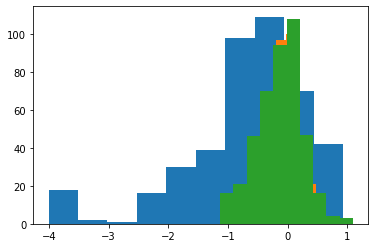

In [19]:
df_diff.groupby(['Component'])['Amplitude'].hist(grid=False)
plt.show()

## Examine distribution of peak latencies

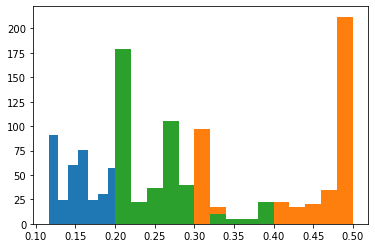

In [20]:
df_diff.groupby(['Component'])['PeakLat'].hist(grid=False)
plt.show()

## Examine distribution of peak channels

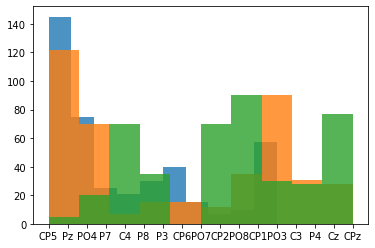

In [21]:
df_diff.groupby(['Component'])['PeakChan'].hist(grid=False, alpha=.8)
plt.show()

## Statistics

We perform a *t*-test for each individual, between violation and control, based on the N400 measurements from above — i.e., 200 ms averages centred around the peak time, at the peak electrode.

### Aggregate (average) over channels within each ROI/Component/participant_id

This is the input to the *t* tests

In [26]:
df_agg = df_all.groupby(['participant_id', 'Component', 'ROI', 'Condition']).mean()

df_agg

PeakLat  Amplitude
participant_id Component ROI    Condition                                 
sub-001        n170      left   Angry/Grey/nontarget      0.132  -0.282343
                                Angry/Grey/target         0.234  -0.223951
                                Angry/Red/nontarget       0.170   0.327519
                                Angry/Red/target          0.152   0.453808
                                Neutral/Grey/nontarget    0.230  -0.189732
                                Neutral/Grey/target       0.166   0.007304
                                Neutral/Red/nontarget     0.184  -0.209114
                                Neutral/Red/target        0.138   0.040130
                                nontarget                 0.236   0.168136
                                target                    0.152   0.066021
                         right  Angry/Grey/nontarget      0.170   0.024256
                                Angry/Grey/target         0.176  -0.050145
                                Angry/Red/nontarget       0.108  -0.383329
                                Angry/Red/target          0.178  -1.035038
                                Neutral/Grey/nontarget    0.108   0.003881
                                Neutral/Grey/target       0.122   0.145517
                                Neutral/Red/nontarget     0.112  -0.485439
                                Neutral/Red/target        0.136  -1.011467
                                nontarget                 0.108  -0.115722
                                target                    0.126  -0.171047
                         vertex Angry/Grey/nontarget      0.228  -0.081866
                                Angry/Grey/target         0.232  -0.468732
                                Angry/Red/nontarget       0.240  -0.072916
                                Angry/Red/target          0.128  -0.628452
                                Neutral/Grey/nontarget    0.136  -0.186184
                                Neutral/Grey/target       0.200  -1.184834
                                Neutral/Red/nontarget     0.232  -0.207339
                                Neutral/Red/target        0.208  -0.308795
                                nontarget                 0.232  -0.140480
                                target                    0.214  -0.456989
               n400f     left   Angry/Grey/nontarget      0.376  -0.130994
                                Angry/Grey/target         0.500   0.229039
                                Angry/Red/nontarget       0.400  -0.228408
                                Angry/Red/target          0.300   0.165107
                                Neutral/Grey/nontarget    0.316  -0.178978
                                Neutral/Grey/target       0.470  -0.060888
                                Neutral/Red/nontarget     0.470  -0.055757
                                Neutral/Red/target        0.438  -0.063639
                                nontarget                 0.402  -0.078265
                                target                    0.366  -0.103839
                         right  Angry/Grey/nontarget      0.424  -0.341639
                                Angry/Grey/target         0.454  -0.491310
                                Angry/Red/nontarget       0.458  -0.158231
                                Angry/Red/target          0.456  -0.104882
                                Neutral/Grey/nontarget    0.370  -0.319808
                                Neutral/Grey/target       0.402  -0.248777
                                Neutral/Red/nontarget     0.454  -0.026066
                                Neutral/Red/target        0.390   0.045844
                                nontarget                 0.432  -0.188563
                                target                    0.452  -0.195574
                         vertex Angry/Grey/nontarget      0.482  -0.022323
                                Angry/Grey/target         0.414   0.078349
      

In [31]:
contrasts

{'Angry/Grey': ['Angry/Grey/target', 'Angry/Grey/nontarget'],
 'Angry/Red': ['Angry/Red/target', 'Angry/Red/nontarget'],
 'Neutral/Grey': ['Neutral/Grey/target', 'Neutral/Grey/nontarget'],
 'Neutral/Red': ['Neutral/Red/target', 'Neutral/Red/nontarget'],
 'Target-Nontarget': ['target', 'nontarget']}

In [33]:
dfi.sample(12)

,,,,PeakLat,PeakChan,Channel,Amplitude
participant_id,Component,ROI,Condition,,,,
sub-001,n170,right,Neutral/Red/nontarget,0.112,P8,CP6,-2.023819
sub-004,n400f,left,Angry/Grey/target,0.500,PO3,PO3,0.215012
sub-005,n170,vertex,Angry/Grey/nontarget,0.226,Pz,Cz,6.877523
sub-003,p3,vertex,Angry/Grey/nontarget,0.228,Cz,CPz,-0.456002
sub-002,n400f,left,Angry/Grey/target,0.478,P3,P7,2.151384
sub-001,n400f,vertex,Angry/Grey/nontarget,0.482,Cz,CPz,0.005906
sub-005,p3,left,Angry/Grey/nontarget,0.400,PO3,P3,-0.074692
sub-002,p3,right,Neutral/Red/nontarget,0.362,P4,PO8,0.489670
sub-001,p3,right,Neutral/Red/nontarget,0.308,P8,P4,-4.047212


In [35]:
%%time
df_list = []
dfi = df_all.set_index(['participant_id', 'Component', 'ROI', 'Condition'])
for component in components:
     for subj in subjects:
            for contr_name, contr in contrasts.items():
                for roi in rois:
                     a = dfi.loc[(subj, component, roi, contr[0]), 'Amplitude']
                     b = dfi.loc[(subj, component, roi, contr[1]), 'Amplitude']
# conduct t test
                     t, p = ttest_ind(a, b)
                     df_list.append(pd.DataFrame({'participant_id':subj,
                                                  'Component':component,
                                                  'ROI':roi,
                                                  'Contrast':contr_name,
                                                  't':t.round(2),
                                                  'p':p.round(4)
                                                 },
                                                 index=[0]
                                                )
                                   )
df_ttest = pd.concat(df_list, ignore_index=True)                       
df_ttest['p (corr.)'] = multipletests(df_ttest['p'], alpha=.05, method='fdr_bh')[1].round(4)
df_ttest.to_csv('indiv_subj_ttests.csv', index=False)
# df_ttest.sort_values(by='t', axis=0)

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:889: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


CPU times: user 9.28 s, sys: 502 ms, total: 9.78 s
Wall time: 9.78 s


,participant_id,Component,ROI,Contrast,t,p,p (corr.)
141,sub-005,p3,left,Neutral/Grey,-37.95,0.0000,0.0000
126,sub-004,p3,left,Neutral/Grey,-37.95,0.0000,0.0000
179,sub-002,n400f,right,Target-Nontarget,-33.78,0.0000,0.0000
29,sub-002,n170,right,Target-Nontarget,-32.58,0.0000,0.0000
27,sub-002,n170,left,Target-Nontarget,-29.85,0.0000,0.0000
44,sub-003,n170,right,Target-Nontarget,-26.28,0.0000,0.0000
59,sub-004,n170,right,Target-Nontarget,-25.15,0.0000,0.0000
74,sub-005,n170,right,Target-Nontarget,-25.15,0.0000,0.0000
176,sub-002,n400f,right,Neutral/Red,-24.81,0.0000,0.0000
20,sub-002,n170,right,Angry/Red,-22.91,0.0000,0.0000


### See all t values

In [38]:
df_ttest_all.set_index([ 'Component', 'participant_id', 'Contrast', 'ROI'])

t       p  p (corr.)
Component participant_id Contrast         ROI                             
n170      sub-001        Angry/Grey       left     0.33  0.7383     0.7910
                                          vertex  -2.65  0.0080     0.0240
                                          right   -0.42  0.6765     0.7611
                         Angry/Red        left     0.66  0.5083     0.6182
                                          vertex  -3.45  0.0006     0.0025
                                          right   -3.16  0.0016     0.0060
                         Neutral/Grey     left     1.04  0.2977     0.4619
                                          vertex  -6.60  0.0000     0.0000
                                          right    0.79  0.4314     0.5980
                         Neutral/Red      left     1.38  0.1677     0.3144
                                          vertex  -0.67  0.5055     0.6182
                                          right   -2.98  0.0029     0.0100
                         Target-Nontarget left    -1.10  0.2720     0.4371
                                          vertex  -4.11  0.0000     0.0000
                                          right   -0.59  0.5534     0.6553
p3        sub-001        Angry/Grey       left    -0.35  0.7270     0.7910
                                          vertex  -4.84  0.0000     0.0000
                                          right    0.51  0.6083     0.7019
                         Angry/Red        left     0.77  0.4385     0.5980
                                          vertex  -4.12  0.0000     0.0000
                                          right   -2.35  0.0188     0.0498
                         Neutral/Grey     left     2.94  0.0033     0.0106
                                          vertex   4.21  0.0000     0.0000
                                          right   -0.75  0.4553     0.6026
                         Neutral/Red      left     1.86  0.0625     0.1406
                                          vertex   1.16  0.2475     0.4180
                                          right   -1.21  0.2263     0.4073
                         Target-Nontarget left     3.56  0.0004     0.0020
                                          vertex  -1.88  0.0601     0.1406
                                          right   -1.89  0.0594     0.1406
n400f     sub-001        Angry/Grey       left     5.28  0.0000     0.0000
                                          vertex   1.44  0.1509     0.2952
                                          right   -2.46  0.0138     0.0388
                         Angry/Red        left     6.36  0.0000     0.0000
                                          vertex  -3.58  0.0003     0.0017
                                          right    0.69  0.4900     0.6182
                         Neutral/Grey     left     1.49  0.1351     0.2763
                                          vertex  -1.62  0.1047     0.2244
                                          right    1.15  0.2508     0.4180
                         Neutral/Red      left    -0.10  0.9200     0.9409
                                          vertex  -0.04  0.9692     0.9692
                                          right    1.02  0.3092     0.4638
                         Target-Nontarget left    -0.93  0.3545     0.5146
                                          vertex  -3.46  0.0005     0.0023
                                          right   -0.21  0.8302     0.8688
n170      sub-002        Angry/Grey       left   -14.79  0.0000     0.0000
                                          vertex  -7.50  0.0000     0.0000
                                          right  -19.46  0.0000     0.0000
                         Angry/Red        left   -15.07  0.0000     0.0000
                                          vertex  -1.43  0.1517     0.1588
                                          right  -22.91  0.0000     0.0000
                         Neutral/Grey     left   -11.58  0.0000     0.0000
    

## Show only the significant t values (after FDR correction)

Using a corrected *p* threshold of .05

In [40]:
df_ttest_all.set_index([ 'Component', 'participant_id', 'Contrast', 'ROI']).loc[multipletests(df_ttest['p'], alpha=.05, method='fdr_bh')[0], :]

t       p  p (corr.)
Component participant_id Contrast         ROI                             
n170      sub-001        Angry/Grey       vertex  -2.65  0.0080     0.0240
                         Angry/Red        vertex  -3.45  0.0006     0.0025
                                          right   -3.16  0.0016     0.0060
                         Neutral/Grey     vertex  -6.60  0.0000     0.0000
                         Neutral/Red      right   -2.98  0.0029     0.0100
                         Target-Nontarget vertex  -4.11  0.0000     0.0000
p3        sub-001        Angry/Grey       left    -0.35  0.7270     0.7910
                                          vertex  -4.84  0.0000     0.0000
                                          right    0.51  0.6083     0.7019
                         Angry/Red        left     0.77  0.4385     0.5980
                                          right   -2.35  0.0188     0.0498
                         Neutral/Grey     left     2.94  0.0033     0.0106
                                          vertex   4.21  0.0000     0.0000
                                          right   -0.75  0.4553     0.6026
                         Neutral/Red      left     1.86  0.0625     0.1406
                                          right   -1.21  0.2263     0.4073
                         Target-Nontarget left     3.56  0.0004     0.0020
                                          vertex  -1.88  0.0601     0.1406
                                          right   -1.89  0.0594     0.1406
n400f     sub-001        Angry/Grey       left     5.28  0.0000     0.0000
                                          vertex   1.44  0.1509     0.2952
                                          right   -2.46  0.0138     0.0388
                         Angry/Red        left     6.36  0.0000     0.0000
                                          vertex  -3.58  0.0003     0.0017
                                          right    0.69  0.4900     0.6182
                         Neutral/Grey     vertex  -1.62  0.1047     0.2244
                                          right    1.15  0.2508     0.4180
                         Neutral/Red      left    -0.10  0.9200     0.9409
                                          vertex  -0.04  0.9692     0.9692
                                          right    1.02  0.3092     0.4638
                         Target-Nontarget left    -0.93  0.3545     0.5146
                                          vertex  -3.46  0.0005     0.0023
                                          right   -0.21  0.8302     0.8688
n170      sub-002        Angry/Grey       left   -14.79  0.0000     0.0000
                                          vertex  -7.50  0.0000     0.0000
                                          right  -19.46  0.0000     0.0000
                         Angry/Red        left   -15.07  0.0000     0.0000
                                          vertex  -1.43  0.1517     0.1588
                                          right  -22.91  0.0000     0.0000
                         Neutral/Grey     left   -11.58  0.0000     0.0000
                                          vertex -12.18  0.0000     0.0000
                                          right  -14.78  0.0000     0.0000
                         Neutral/Red      vertex  -0.31  0.7537     0.7537
                                          right   -8.81  0.0000     0.0000
                         Target-Nontarget left   -29.85  0.0000     0.0000
                                          vertex -14.10  0.0000     0.0000
                                          right  -32.58  0.0000     0.0000
p3        sub-002        Angry/Grey       left     8.31  0.0000     0.0000
                                          vertex  -9.78  0.0000     0.0000
                                          right    5.68  0.0000     0.0000
                         Angry/Red        left     2.49  0.0130     0.0139
                                          vertex  -8.08  0.0000     0.0000
    

In [ ]:
sig_subjs = multipletests(df_ttest['p'], alpha=.05, method='fdr_bh')[0].sum()
pct_sig_subj = round(((sig_subjs / len(df_ttest)) * 100), 1)
print('Percentage of t tests showing significant effects:', str(pct_sig_subj), '%')
print('(corrected for multiple comparisions using false discovery rate)')